In [2]:
import torch
import tal
import numpy as np

from model.nerf import NLOSNeRF
from model.scene import Scene
from matplotlib import pyplot as plt

In [2]:
sensor_x = 32
sensor_y = 32
scale = 1
t_max = 256
arg_start = 0
arg_end = torch.pi
delta_m_meters = 0.05
n_spherical_coarse_bins = 9
scene = Scene(sensor_x=sensor_x, sensor_y=sensor_y)
model = NLOSNeRF()

In [3]:
r_max = delta_m_meters * t_max / 2
rw = scene.relay_wall()
    
x_min, x_max = torch.min(rw[..., 0]) - r_max, torch.max(rw[..., 0]) + r_max
y_min, y_max = torch.min(rw[..., 1]) - r_max, torch.max(rw[..., 1]) + r_max
z_min, z_max = 0, r_max

In [22]:
center = np.array([0, 0, 0.5])
sensor_res_x = 128
sensor_res_y = 128
device_uri_gpu = "cuda:0"
model = NLOSNeRF().to(device=device_uri_gpu)
dict_ = torch.load("./data/models/usaf-single-oneshot-32-b4-lcs.pth")
model.load_state_dict(dict_["model_state_dict"])
dx = 1 / np.sqrt(2)
dy = 1 / np.sqrt(2)
dz = 1 / np.sqrt(2)
xv = torch.linspace(start=center[0]+(dx/2), end=center[0]-(dx/2), steps=sensor_res_x)
yv = torch.linspace(start=center[1]+(dy/2), end=center[1]-(dy/2), steps=sensor_res_y)
zv = torch.linspace(start=center[2]-(dz/2), end=center[2]+(dy/2), steps=sensor_res_x)
X, Y, Z = torch.meshgrid(xv, yv, zv, indexing="ij")
stack_pts = torch.stack((-Y, -X, Z), axis=-1)
stack_dirs = (torch.pi / 2) * torch.ones((sensor_res_x, sensor_res_y, sensor_res_x, 2))
stack_input = torch.cat((stack_pts, stack_dirs), dim=-1)
with torch.no_grad():
    result = model(model.fourier_encoding(stack_input, x_min=x_min, x_max=x_max, y_min=y_min, y_max=y_max, z_min=z_min, z_max=z_max).to(device=device_uri_gpu))
    result = torch.prod(result, dim=-1).detach().cpu().numpy()
    rec = np.max(result, axis=-1)

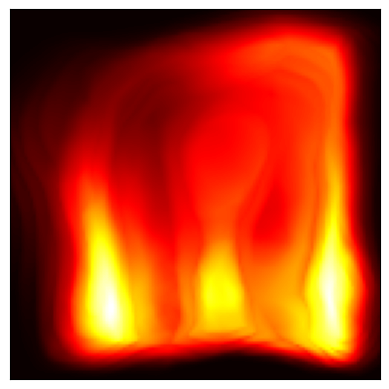

In [23]:
fig, ax = plt.subplots()
ax.set_xticks([])
ax.set_yticks([])
ax.imshow(rec, cmap="hot")

In [3]:
path = "./data/Z-scene/Z-scene.hdf5"
gt_data = tal.io.read_capture(path)
tal.reconstruct.compensate_laser_cos_dsqr(gt_data)
gt_H = torch.from_numpy(gt_data.H)
center = np.array([0, 0, 0.5])

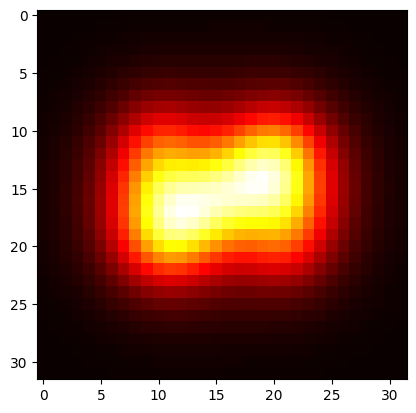

In [4]:
projected_lc = torch.sum(gt_H, dim=0)
projected_lc_np = projected_lc.cpu().detach().numpy()
mean = np.mean(projected_lc_np)
std = np.std
plt.imshow(projected_lc_np, cmap="hot")

In [3]:
def get_volume(nx, ny, center):
    """_summary_

    Args:
        nx (_type_): _description_
        ny (_type_): _description_
    """
    dx = 1 / np.sqrt(2)
    dy = 1 / np.sqrt(2)
    dz = 1 / np.sqrt(2)
    xv = np.linspace(start=center[0]-dx/2, stop=center[0]+dx/2, num=nx)
    yv = np.linspace(start=center[1]-dy/2, stop=center[1]+dy/2, num=ny)
    zv = np.linspace(start=center[2]-dz/2, stop=center[2]+dz/2, num=nx)
    X, Y, Z = np.meshgrid(xv, yv, zv)
    return np.stack((X, -Y, Z), axis=-1)

volume_xyz = get_volume(64, 64, center=center)

In [4]:
with tal.resources(8):
    rec = tal.reconstruct.fbp.solve(
        data=gt_data,  volume_xyz=volume_xyz, wl_mean=0.2, wl_sigma=0.2
    )

tal.reconstruct.filter_H: Using wavelengths from 0.1328m to 0.4071m
tal.resources: Using 8 CPU processes and downscale 8.


tal.resources progress: 100%|██████████| 8/8 [00:00<00:00, 30.20it/s]            


tal.reconstruct.utils: Assuming that volume_xyz is X_Y_Z_3
tal.resources: Using 8 CPU processes and downscale 8.


tal.resources progress: 100%|██████████| 8/8 [01:22<00:00, 10.37s/it]


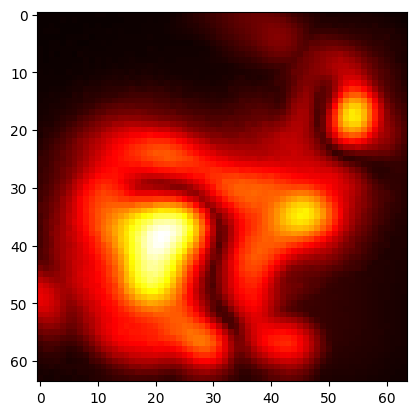

In [5]:
plt.imshow(np.max(np.abs(rec), axis=-1), cmap="hot")